<a href="https://colab.research.google.com/github/KalanaBimsara/Bank-Client-Prediction/blob/main/CW_ML_CM2604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
!pip install imblearn
from imblearn.over_sampling import SMOTE




In [68]:
# Load the dataset
file_path = '/content/drive/MyDrive/CW_ML/bank-additional-full.csv'
data = pd.read_csv(file_path, sep=';')  # The dataset uses a semicolon as the delimiter

# Display the first few rows and basic info
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None,
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Drop irrelevant or redundant columns
# These columns are removed because they are either not useful for prediction

columns_to_drop = ['contact', 'day_of_week', 'month', 'poutcome']
data.drop(columns=columns_to_drop, inplace=True)

# Step 2: Handle missing/unknown values
# Replace "unknown" with NaN for consistency and handle missing values
data.replace('unknown', pd.NA, inplace=True)

# Impute missing values
for col in data.columns:
    if data[col].isna().sum() > 0:
        if data[col].dtype == 'object':
            # Fill missing values in categorical columns with the mode
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            # Fill missing values in numerical columns with the median
            data[col] = data[col].fillna(data[col].median())

# Step 3: Encode categorical features
# Encode the target variable (binary target, 1 = yes, 0 = no)
label_enc = LabelEncoder()
data['y'] = label_enc.fit_transform(data['y'])  # 1 = yes, 0 = no

# One-hot encode other categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # Avoid dummy variable trap

# Step 4: Separate features and target
X = data.drop('y', axis=1)
y = data['y']

# Step 5: Handle imbalanced classes using SMOTE
# Oversampling the minority class to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify class balance after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Step 6: Train-Test Split
# Stratified splitting to preserve the class distribution in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Step 7 (Optional): Feature Scaling
# Scale features for distance-based models (e.g., SVM, Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Summary
print("Preprocessing completed.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{pd.Series(y_train).value_counts()}")



Class distribution after SMOTE:
y
0    36548
1    36548
Name: count, dtype: int64
Preprocessing completed.
X_train shape: (51167, 31)
X_test shape: (21929, 31)
y_train distribution:
y
1    25584
0    25583
Name: count, dtype: int64


In [70]:
# Display the preprocessed data
print("Preprocessed Data:")
print(data.head())


Preprocessed Data:
   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  marital_single  \
0          -36.4      4.857       5191.0  ...           False   
1          -36.4      4.857       5191.0  ...           False   
2          -36.4      4.857       5191.0  ...           False   
3          -36.4      4.857       5191.0  ...           False   
4          -36.4      4.857       5191.0  ...           False   

   education_basic.6y  education_basic.9y  education_high.school  \
0               False               False                  

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     10965
           1       0.94      0.97      0.95     10964

    accuracy                           0.95     21929
   macro avg       0.95      0.95      0.95     21929
weighted avg       0.95      0.95      0.95     21929

Accuracy: 0.95


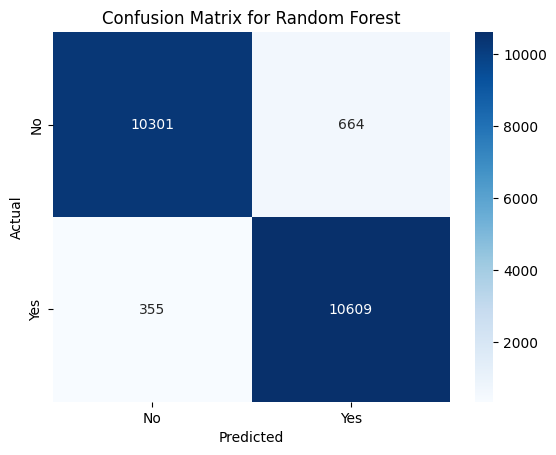

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Initialize Random Forest with 100 trees (n_estimators = 100)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Train the model
rf_model.fit(X_train, y_train)

# Step 3: Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Step 4: Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

# Step 5: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

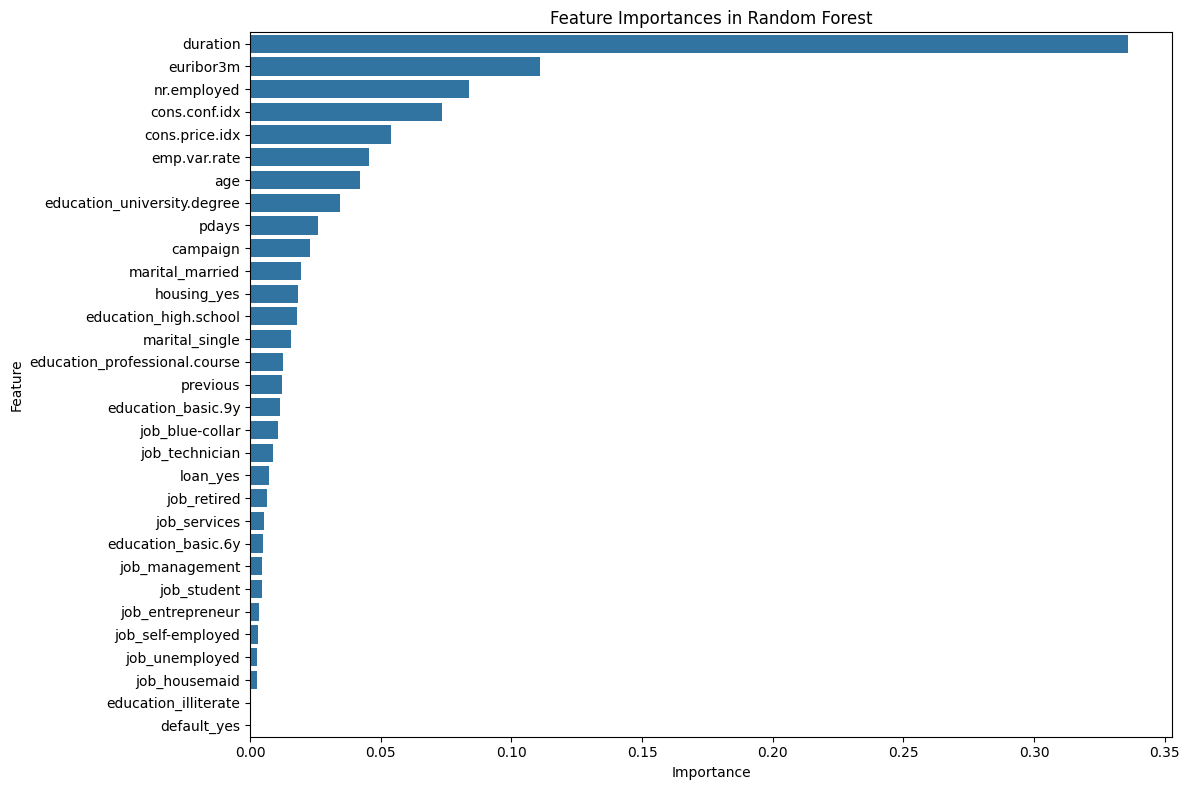

In [72]:
# Step 6: Feature Importance Visualization
importances = rf_model.feature_importances_

# Retrieve column names from the original dataset (before scaling)
features = X.columns  # Use the original column names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot All Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [73]:
# Step 7: Predict the first 10 clients in the test set
predictions_first_10 = rf_model.predict(X_test[:10])
print("Predictions for the first 10 clients in the test set:")
for idx, pred in enumerate(predictions_first_10, start=1):
    print(f"Client {idx}: {'Subscribed' if pred == 1 else 'Not Subscribed'}")

# Optional: Display actual values for comparison
print("\nActual values for the first 10 clients in the test set:")
actual_first_10 = y_test[:10].values
for idx, actual in enumerate(actual_first_10, start=1):
    print(f"Client {idx}: {'Subscribed' if actual == 1 else 'Not Subscribed'}")


Predictions for the first 10 clients in the test set:
Client 1: Not Subscribed
Client 2: Not Subscribed
Client 3: Not Subscribed
Client 4: Not Subscribed
Client 5: Subscribed
Client 6: Subscribed
Client 7: Subscribed
Client 8: Subscribed
Client 9: Subscribed
Client 10: Subscribed

Actual values for the first 10 clients in the test set:
Client 1: Not Subscribed
Client 2: Not Subscribed
Client 3: Not Subscribed
Client 4: Not Subscribed
Client 5: Subscribed
Client 6: Subscribed
Client 7: Subscribed
Client 8: Subscribed
Client 9: Subscribed
Client 10: Not Subscribed


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

# Initialize Neural Network
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict probabilities on test data
print("-------------------------------------------------------------------------------------------------------------------------")
y_proba_nn = nn_model.predict(X_test_scaled)
y_pred_nn = (y_proba_nn > 0.5).astype("int32")

# Evaluate the model
print("-------------------------------------------------------------------------------------------------------------------------")
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")

Epoch 1/50
1280/1280 [==============================] - 4s 2ms/step - loss: 0.4302 - accuracy: 0.8025 - val_loss: 0.3621 - val_accuracy: 0.8381
Epoch 2/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3778 - accuracy: 0.8305 - val_loss: 0.3499 - val_accuracy: 0.8405
Epoch 3/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3660 - accuracy: 0.8342 - val_loss: 0.3545 - val_accuracy: 0.8421
Epoch 4/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3592 - accuracy: 0.8364 - val_loss: 0.3457 - val_accuracy: 0.8430
Epoch 5/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3563 - accuracy: 0.8392 - val_loss: 0.3405 - val_accuracy: 0.8436
Epoch 6/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3554 - accuracy: 0.8384 - val_loss: 0.3390 - val_accuracy: 0.8446
Epoch 7/50
1280/1280 [==============================] - 3s 2ms/step - loss: 0.3497 - accuracy: 0.8406 - val_loss: 0.3367 - val_accuracy:

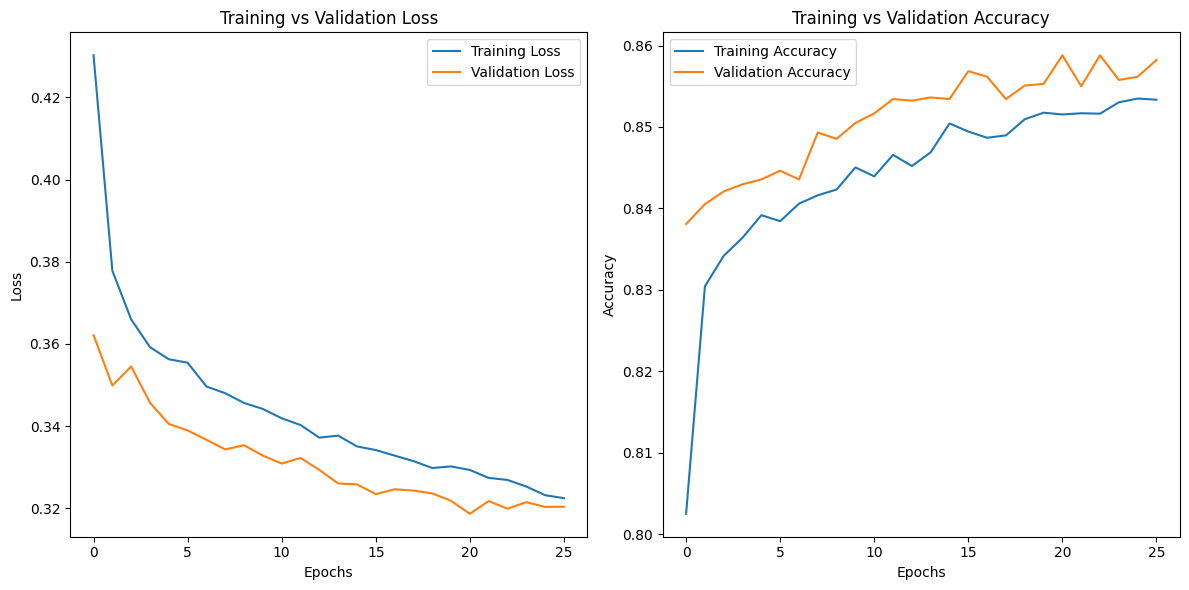

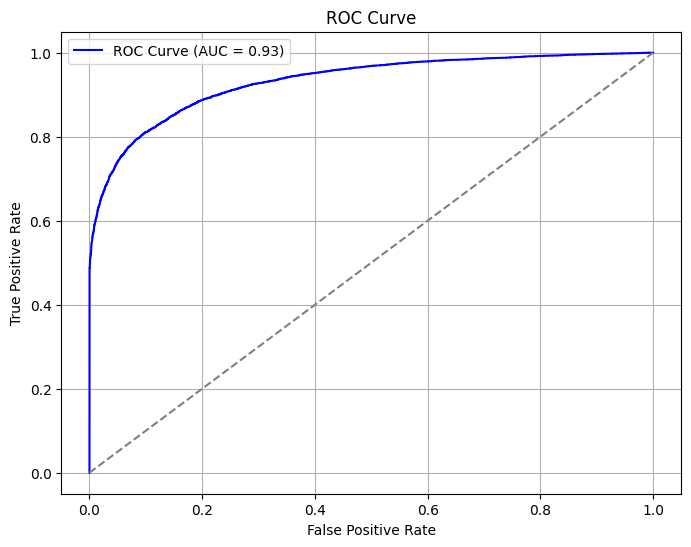

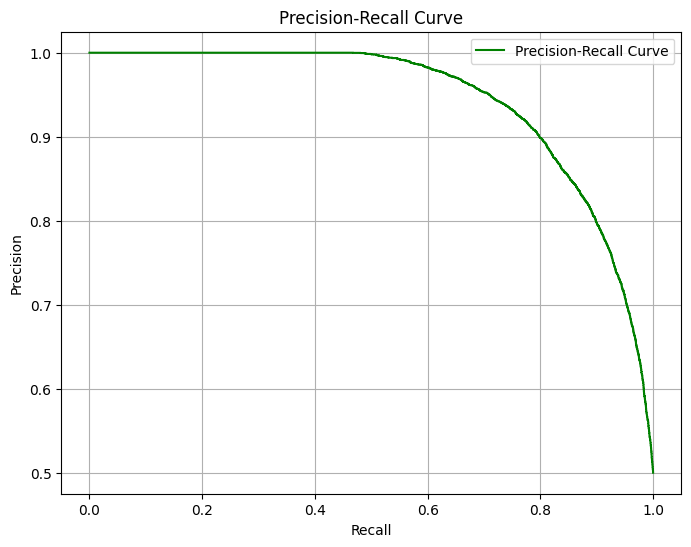

In [75]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_nn)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()




In [76]:
# Predict for the first 10 clients in the test set
first_10_predictions = nn_model.predict(X_test_scaled[:10])
first_10_labels = (first_10_predictions > 0.5).astype("int32")

print("Predictions for the first 10 clients in the test set:")
for i, (proba, pred) in enumerate(zip(first_10_predictions.flatten(), first_10_labels.flatten())):
    print(f"Client {i + 1}: Predicted Probability = {proba:.2f}, Predicted Class = {pred}")

1/1 [==============================] - 0s 24ms/step
Predictions for the first 10 clients in the test set:
Client 1: Predicted Probability = 0.32, Predicted Class = 0
Client 2: Predicted Probability = 0.15, Predicted Class = 0
Client 3: Predicted Probability = 0.05, Predicted Class = 0
Client 4: Predicted Probability = 0.59, Predicted Class = 1
Client 5: Predicted Probability = 1.00, Predicted Class = 1
Client 6: Predicted Probability = 1.00, Predicted Class = 1
Client 7: Predicted Probability = 0.90, Predicted Class = 1
Client 8: Predicted Probability = 1.00, Predicted Class = 1
Client 9: Predicted Probability = 1.00, Predicted Class = 1
Client 10: Predicted Probability = 0.49, Predicted Class = 0
